In [110]:
import sys
import os
import re

from rdflib import Graph, URIRef, Literal, Namespace, RDF, RDFS
from rdflib import OWL, RDF, RDFS, XSD, TIME
from rdflib.plugins.stores.memory import Memory

import networkx as nx
import matplotlib.pyplot as plt
import scipy

In [111]:
#  Directory configurations
csmodl_patterns_folder = os.path.join(".", "csmodl", "patterns")
enslaved_patterns_folder =  os.path.join(".", "enslaved-modl", "patterns")

# Prefix Configurations
name_space = "https://kastle.cs.wright.edu/"
csmold_namespace = "https://kastle.cs.wright.edu/csmodl#"
enslaved_namespace = "https://kastle.cs.wright.edu/enslaved-modl#"
modl_namespace = "https://archive.org/services/purl/purl/modular_ontology_design_library#"
opla_namespace = "https://ontologydesignpatterns.org/"

pfs = {
"": Namespace(f"{name_space}"),
"csmodl": Namespace(f"{csmold_namespace}"),
"enslaved": Namespace(f"{enslaved_namespace}"),
"kl-res": Namespace(f"{name_space}lod/resource/"),
"kl-ont": Namespace(f"{name_space}lod/ontology/"),
"modl" : Namespace(f"{modl_namespace}"),
"rdf": RDF,
"rdfs": RDFS,
"xsd": XSD,
"owl": OWL,
"time": TIME,
"dc": Namespace("http://purl.org/dc/elements/1.1/"),
"opla": Namespace("http://ontologydesignpatterns.org/opla#"),
"opla-core": Namespace("http://ontologydesignpatterns.org/opla-core#"),
"opla-sd": Namespace("http://ontologydesignpatterns.org/opla-sd#"),
"opla-cp": Namespace("http://ontologydesignpatterns.org/opla-cp#"),
}

# Property Shortcuts
a = pfs["rdf"]["type"]

# URIs of Class Representation
classURIs = [URIRef("http://www.w3.org/2002/07/owl#Class"),
            URIRef('http://www.w3.org/2000/01/rdf-schema#Class')]

# URIs of Relationship/Property Representation
propURIs = [
    pfs["rdf"]["Property"],
    pfs["owl"]["ObjectProperty"],
    pfs["owl"]["DatatypeProperty"]
]

# Subclass Of
scoURI = pfs["rdfs"]["subClassOf"]


def strip_uri(uri):
    '''
        Helper function to extract name from a URI
    '''
    tokens = re.split("[#/]", uri)
    name = tokens[-1]
    if tokens[-1]=="":
        name = tokens[len(tokens)-2]

    return name

52
59


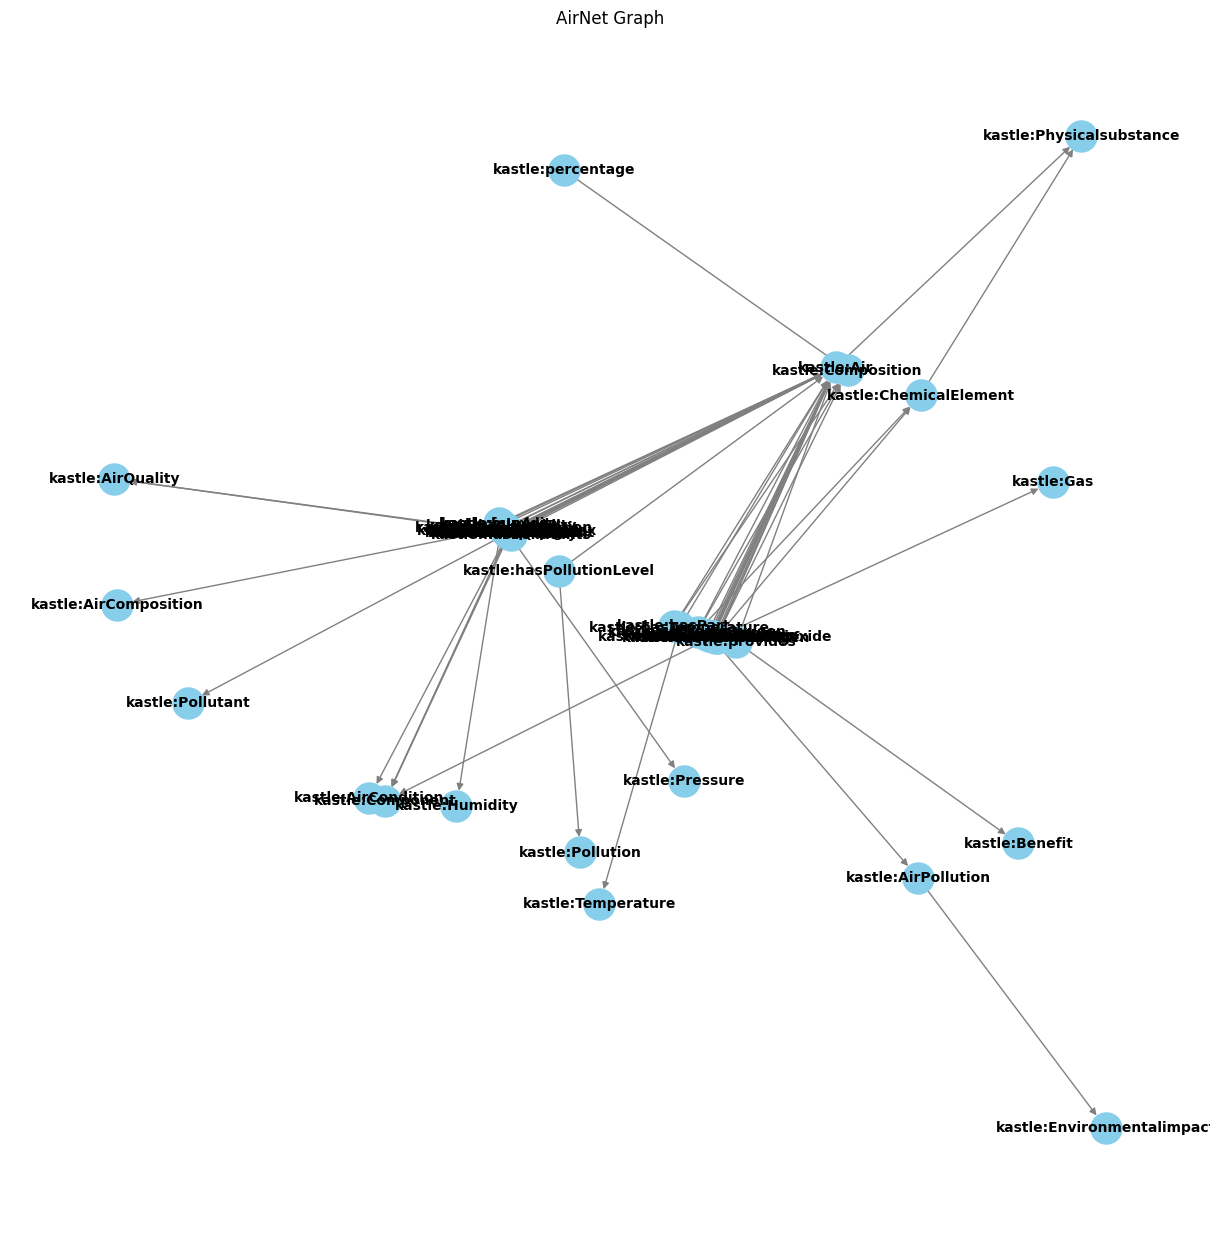

In [112]:
# For testing, confirming functionality with single file: Air.ttl
air = Graph()
airNet = nx.DiGraph()
airNS = [] # Used for cleaning up namespaces in final output

with open(os.path.join(csmodl_patterns_folder, "Air.ttl"), 'r') as f:
    data = f.read()
    air.parse(data=data, format='turtle')

for ns in air.namespaces():
    air.bind(ns[0], ns[1])
    airNS.append(ns)

for s, p, o in air:
    for ns in airNS:
        if ns[1] in s:
            s = str(s).replace(ns[1], ns[0]+":")
        if ns[1] in o:
            o = str(o).replace(ns[1], ns[0]+":")
        if ns[1] in p:
            p = str(p).replace(ns[1], ns[0]+":")
    if s.startswith("kastle") and o.startswith("kastle"):
        airNet.add_node(s)
        airNet.add_node(o)
        airNet.add_edge(s, o, label=p)

print(airNet.number_of_nodes())
print(airNet.number_of_edges())


plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(airNet)

nx.draw(airNet, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
plt.title("AirNet Graph")
plt.show()

CS-MODL Nodes: 619
CS-MODL Edges: 1250
{'Group', 'Person', 'Classroom', 'Part', 'Community', 'Employee', 'Thing', 'Computer', 'Subject', 'Day', 'Night', 'Side', 'Place', 'Air', 'Work', 'Case', 'Desk', 'Course', 'Department', 'System', 'Way', 'Parent', 'Event', 'Manufacturer', 'Product', 'President', 'JobPosting', 'Study', 'Education', 'Teacher', 'Assembly', 'Component', 'Service', 'Language', 'Anyuri', 'Process', 'Change', 'Member', 'Student', 'Party', 'Home', 'Moment', 'Car', 'Customer', 'Research', 'Mother', 'Researcher', 'Room', 'Provider', 'Moon', 'Office', 'Idea', 'Man', 'Entity', 'Client', 'Lawyer', 'Employer', 'Agent', 'Country', 'House', 'Friend', 'Right', 'Organization', 'Human', 'Post', 'Star', 'Week', 'Law', 'State', 'Woman', 'Class', 'Year', 'Child', 'Judge', 'Male', 'City', 'Other', 'HistoricalEvent', 'School', 'Task', 'Comment', 'Job', 'Company', 'Presidency', 'Professor', 'Institution', 'Family', 'Branch', 'Government'}
Nodes in the largest connected component:	89
Edges 

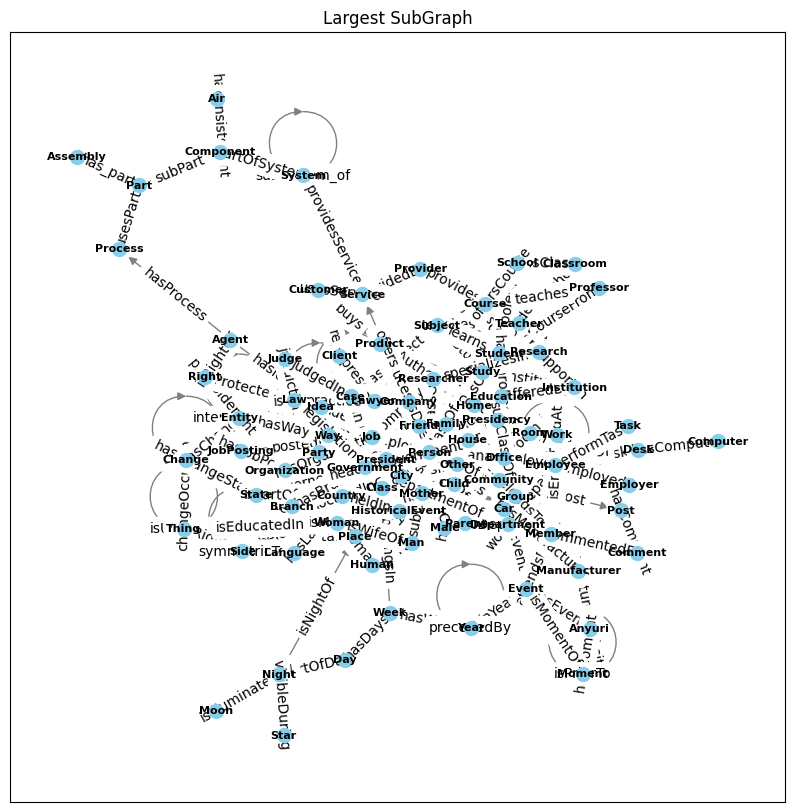

In [113]:
# All CS-MODL patterns
cs_kg = Graph()
for prefix in pfs:
    cs_kg.bind(prefix, pfs[prefix])
gNet = nx.DiGraph()

# Load in TTL files to RDFLib Graph structure
for filename in os.listdir(csmodl_patterns_folder):
    file_path = os.path.join(csmodl_patterns_folder, filename)
    if os.path.isfile(file_path):
        with open(file_path, 'r') as f:
            data = f.read()
            cs_kg.parse(data=data, format='turtle')
            # for s, p, o in cs_kg.triples((None, None, None)):
            #     sub = str(s).split("#")[-1]
            #     pred = str(p).split("#")[-1]
            #     obj = str(o).split("#")[-1] 

            #     if sub == obj and pred in "subClassOf":
            #         print(filename)  

# Extract Node-Edge-Nodes
for s, p, o in cs_kg.triples((None, RDF.type, None)):
    if o in propURIs: # find a Property URI
        #  Extract domain and range of property
        _,_,prop_domain = list(cs_kg.triples((s, RDFS.domain,  None)))[0]
        _,_,prop_range = list(cs_kg.triples((s, RDFS.range,  None)))[0]

    sub = strip_uri(prop_domain)
    pred = strip_uri(s)
    obj = strip_uri(prop_range) 
    gNet.add_edge(sub, obj, label=pred)

##  Optional SCO inclusion
for s, p, o in cs_kg.triples((None, scoURI, None)):
    # Include SCO for connected components
    if sub == obj and pred == "subClassOf": # ignore same class subsumption
            continue
    sub = strip_uri(s)
    pred = strip_uri(p)
    obj = strip_uri(o) 
    gNet.add_edge(sub, obj, label=pred)

print(f"CS-MODL Nodes: {gNet.number_of_nodes()}")
print(f"CS-MODL Edges: {gNet.number_of_edges()}")


largest_cc = max(nx.strongly_connected_components(gNet), key=len)
print(largest_cc)

largest_subgraph = gNet.subgraph(largest_cc)
# Print the nodes and edges of the largest subgraph
print(f"Nodes in the largest connected component:\t"+
      f"{largest_subgraph.number_of_nodes()}")
# print(largest_subgraph.nodes())
print(f"Edges in the largest connected component:\t" +
      f"{largest_subgraph.number_of_edges()}")
# for e in largest_subgraph.edges():
#     print(e)

edge_labels=nx.get_edge_attributes(largest_subgraph,'label')

plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(largest_subgraph)

nx.draw_networkx_nodes(largest_subgraph, pos, node_size=100, node_color='skyblue')
nx.draw_networkx_edges(largest_subgraph, pos, edge_color='gray', arrowsize=12, width=1)
nx.draw_networkx_labels(largest_subgraph, pos, font_size=8, font_weight='bold')
nx.draw_networkx_edge_labels(largest_subgraph, 
        pos,
        edge_labels=edge_labels
        )
plt.title("Largest SubGraph")
plt.show()


815
1176
{'Governor', 'Sister', 'Country', 'Region', 'Blessing', 'Project', 'Researcher', 'Person', 'Book', 'Biography', 'Biographer', 'State', 'Party', 'Author', 'Enemy', 'ActOfKindness', 'Petition', 'Carpenter'}
Nodes in the largest connected component:	18
Edges in the largest connected component:	33


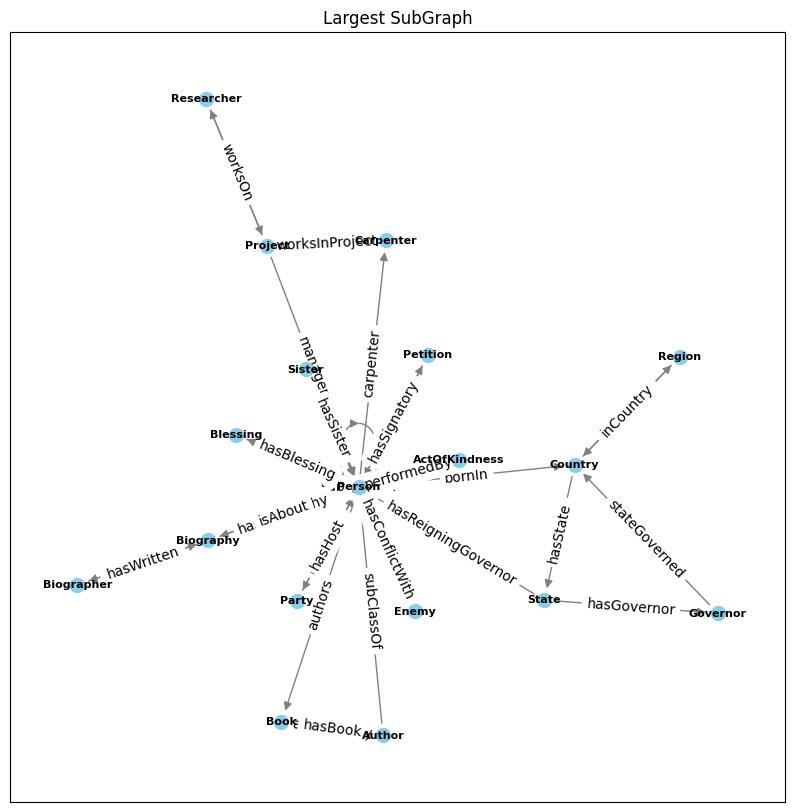

In [114]:
# All Enslaved-MODL patterns
enslaved_kg = Graph()
for prefix in pfs:
    enslaved_kg.bind(prefix, pfs[prefix])
gNet = nx.DiGraph()

# Load in TTL files to RDFLib Graph structure
for filename in os.listdir(enslaved_patterns_folder):
    file_path = os.path.join(enslaved_patterns_folder, filename)
    if os.path.isfile(file_path):
        with open(file_path, 'r') as f:
            data = f.read()
            enslaved_kg.parse(data=data, format='turtle')

# Extract Node-Edge-Nodes
for s, p, o in enslaved_kg.triples((None, RDF.type, None)):
        if o in propURIs: # find a Property URI
            #  Extract domain and range of property
            _,_,prop_domain = list(enslaved_kg.triples((s, RDFS.domain,  None)))[0]
            _,_,prop_range = list(enslaved_kg.triples((s, RDFS.range,  None)))[0]

        sub = strip_uri(prop_domain)
        pred = strip_uri(s)
        obj = strip_uri(prop_range) 
        gNet.add_edge(sub, obj, label=pred)

for s, p, o in enslaved_kg.triples((None, scoURI, None)):
    # Include SCO for connected components
    if sub == obj and pred == "subClassOf": # ignore same class subsumption
            continue
    sub = strip_uri(s)
    pred = strip_uri(p)
    obj = strip_uri(o) 
    gNet.add_edge(sub, obj, label=pred)
    
print(gNet.number_of_nodes())
print(gNet.number_of_edges())


largest_cc = max(nx.strongly_connected_components(gNet), key=len)
print(largest_cc)

largest_subgraph = gNet.subgraph(largest_cc)
# Print the nodes and edges of the largest subgraph
print(f"Nodes in the largest connected component:\t"+
      f"{largest_subgraph.number_of_nodes()}")
# print(largest_subgraph.nodes())
print(f"Edges in the largest connected component:\t" +
      f"{largest_subgraph.number_of_edges()}")
# for e in largest_subgraph.edges():
#     print(e)

edge_labels=nx.get_edge_attributes(largest_subgraph,'label')

plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(largest_subgraph)

nx.draw_networkx_nodes(largest_subgraph, pos, node_size=100, node_color='skyblue')
nx.draw_networkx_edges(largest_subgraph, pos, edge_color='gray', arrowsize=12, width=1)
nx.draw_networkx_labels(largest_subgraph, pos, font_size=8, font_weight='bold')
nx.draw_networkx_edge_labels(largest_subgraph, 
        pos,
        edge_labels=edge_labels
        )
plt.title("Largest SubGraph")
plt.show()


1223
2323
{'Obituary', 'Group', 'Court', 'User', 'Person', 'Official', 'Resource', 'Reason', 'Classroom', 'University', 'Part', 'Governor', 'Community', 'Employee', 'Thing', 'Computer', 'Subject', 'Day', 'Resident', 'Night', 'Side', 'Worker', 'Place', 'Air', 'Work', 'Case', 'Desk', 'Course', 'Piece', 'Department', 'System', 'Something', 'Way', 'Position', 'ServiceProvider', 'Half', 'Origin', 'Girl', 'HistoricalPeriod', 'Parent', 'Event', 'Manufacturer', 'Product', 'President', 'Author', 'JobPosting', 'Study', 'Education', 'Teacher', 'Project', 'Assembly', 'Response', 'LegalRight', 'Component', 'Carpenter', 'Language', 'Book', 'Anyuri', 'Service', 'Role', 'Process', 'Change', 'Supporter', 'Member', 'Authority', 'Student', 'Head', 'Party', 'Home', 'Instance', 'Moment', 'Car', 'Customer', 'Biography', 'Permission', 'Location', 'Enemy', 'Research', 'Mother', 'Sister', 'Access', 'Servant', 'Researcher', 'Room', 'Provider', 'Moon', 'Office', 'Biographer', 'Idea', 'Man', 'Cause', 'Entity', 'A

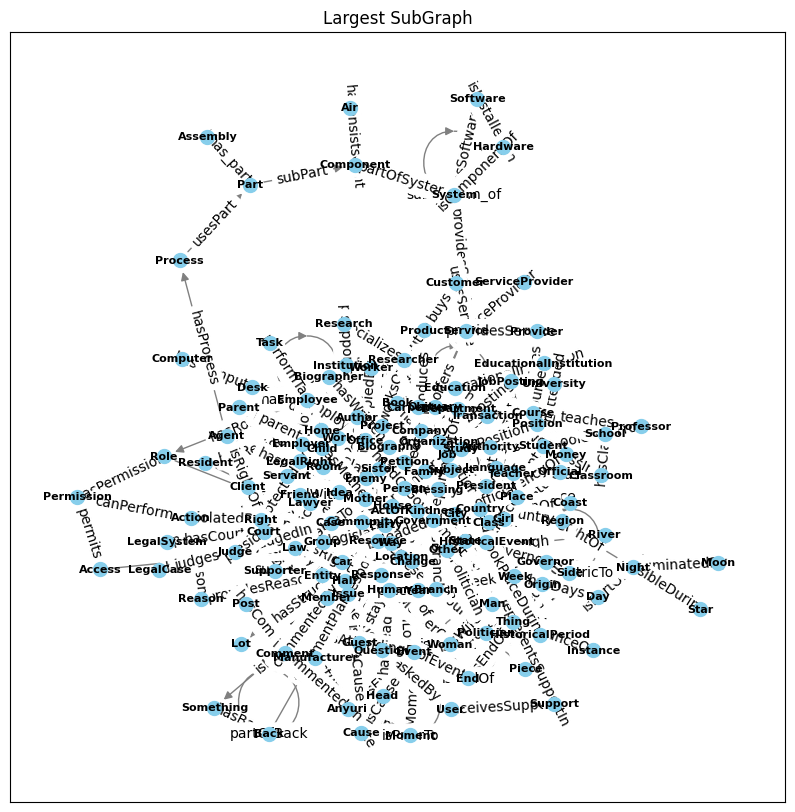

In [115]:
# All CS-MODL patterns
modls_kg = Graph()
for prefix in pfs:
    modls_kg.bind(prefix, pfs[prefix])
gNet = nx.DiGraph()

# Load in TTL files to RDFLib Graph structure
for filename in os.listdir(enslaved_patterns_folder):
    file_path = os.path.join(enslaved_patterns_folder, filename)
    if os.path.isfile(file_path):
        with open(file_path, 'r') as f:
            data = f.read()
            modls_kg.parse(data=data, format='turtle')

for filename in os.listdir(csmodl_patterns_folder):
    file_path = os.path.join(csmodl_patterns_folder, filename)
    if os.path.isfile(file_path):
        with open(file_path, 'r') as f:
            data = f.read()
            modls_kg.parse(data=data, format='turtle')

for s, p, o in modls_kg.triples((None, RDF.type, None)):
    if o in propURIs: # find a Property URI
        #  Extract domain and range of property
        _,_,prop_domain = list(modls_kg.triples((s, RDFS.domain,  None)))[0]
        _,_,prop_range = list(modls_kg.triples((s, RDFS.range,  None)))[0]

    sub = strip_uri(prop_domain)
    pred = strip_uri(s)
    obj = strip_uri(prop_range) 
    gNet.add_edge(sub, obj, label=pred)

for s, p, o in modls_kg.triples((None, scoURI, None)):
    # Include SCO for connected components
    if sub == obj and pred == "subClassOf": # ignore same class subsumption
            continue
    sub = strip_uri(s)
    pred = strip_uri(p)
    obj = strip_uri(o) 
    gNet.add_edge(sub, obj, label=pred)
    
print(gNet.number_of_nodes())
print(gNet.number_of_edges())


largest_cc = max(nx.strongly_connected_components(gNet), key=len)
print(largest_cc)

largest_subgraph = gNet.subgraph(largest_cc)
# Print the nodes and edges of the largest subgraph
print(f"Nodes in the largest connected component:\t"+
      f"{largest_subgraph.number_of_nodes()}")
# print(largest_subgraph.nodes())
print(f"Edges in the largest connected component:\t" +
      f"{largest_subgraph.number_of_edges()}")
# for e in largest_subgraph.edges():
#     print(e)

edge_labels=nx.get_edge_attributes(largest_subgraph,'label')

plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(largest_subgraph)

nx.draw_networkx_nodes(largest_subgraph, pos, node_size=100, node_color='skyblue')
nx.draw_networkx_edges(largest_subgraph, pos, edge_color='gray', arrowsize=12, width=1)
nx.draw_networkx_labels(largest_subgraph, pos, font_size=8, font_weight='bold')
nx.draw_networkx_edge_labels(largest_subgraph, 
        pos,
        edge_labels=edge_labels
        )
plt.title("Largest SubGraph")
plt.show()